# LSTM Recurrent Neural Network ile Döviz Kuru Tahmini

Döviz kurunu tahmin etmek için LSTM Recurrent Neural Network'ü uygulayacağız. LSTM modeli, önceki gözlem dizilerini öğrenmek ve dizideki bir sonraki gözlemi tahmin etmek için eğitilecektir. Türkiye'nin döviz kurunu tahmin etmede bu modeli uygulayacağız.

##### Kütüphanelerin import edilmesi

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras

##### TCMB'nin sitesindeki döviz kuru kayıtlarının çekilmesi

Merkez Bankası Elektronik Veri Dağıtım Sistemi'ne kayıt olunduktan sonra, Merkez Bankası APİ’sinden yararlanmak için siteden bir API key'i alınmıştır. Daha sonra aşağıdaki parametreler kullanılmıştır.

#Parametreler ve Anlamları Şu Şekildedir:

 Series:
- series= Seri kodları gösterilir. Birden fazla seri seçilmesi durumunda, seri sayısı kadar parametre alır, seri kodları "-" işaretiyle ayrılır.                                 
Tarih Parametreleri:
- startDate= Başlangıç tarihini gösterir.
- endDate= Bitiş tarihini gösterir.                         
Biçim Parametreleri:
- type= Web servislerinin dönüş tipi csv, xml ya da json objesi şeklindedir.                                 
Gözlem Parametreleri:
- aggretionType= Verinin toplama türünü gösterir (avg: Ortalama değer, min: En düşük, max: En yüksek, first: Başlangıç, last: Bitiş, sum: Kümülatif).
Frekans Parametreleri:
- frequency= Verinin frekansını belirler (Günlük:1, İşgünü:2, Haftalık:3, Ayda2Kez: 4, Aylık: 5, 3Aylık: 6, 6 Aylık: 7, Yıllık: 8),                                    
Formül Parametreleri:
- formulas= Verinin hangi formüle göre çekileceğini belirler (Düzey:0, Yüzde Değişim: 1, Fark: 2, Yıllık Yüzde Değişim: 3, Yıllık Fark: 4, Bir Önceki Yılın Sonuna Göre Yüzde Değişim: 5, Bir Önceki Yılın Sonuna Göre Fark: 6, Hareketli Ortalama: 7, Hareketli Toplam: 8).                                    
Key:
- key: Kullanıcıya tanımlı API anahtarıdır. API anahtarı her kullanıcı için farklı tanımlanır.

In [30]:
series ="TP.DK.USD.S.YTL"
series_name="Dolar_Kuru"
startDate= "01-03-2020"
endDate="01-03-2022"
typee="csv"
key="JFHFe5F5Ne"
aggregationTypes="avg"
formulas="0"
frequency = "2"

In [93]:
url= 'https://evds2.tcmb.gov.tr/service/evds/series={}&startDate={}&endDate={}&type={}&key={}&aggregationTypes={}&formulas={}&frequency={}'.format(series,startDate,endDate,typee,key,aggregationTypes,formulas,frequency)

dolar = pd.read_csv(url)
dolar.head(250)

,Tarih,TP_DK_USD_S_YTL,UNIXTIME
0,02-03-2020,6.2371,"{""numberLong"":""1583103600""}"
1,03-03-2020,6.2304,"{""numberLong"":""1583190000""}"
2,04-03-2020,6.2055,"{""numberLong"":""1583276400""}"
3,05-03-2020,6.1014,"{""numberLong"":""1583362800""}"
4,06-03-2020,6.0882,"{""numberLong"":""1583449200""}"
...,...,...,...
245,08-02-2021,7.0917,"{""numberLong"":""1612738800""}"
246,09-02-2021,7.0791,"{""numberLong"":""1612825200""}"
247,10-02-2021,7.0949,"{""numberLong"":""1612911600""}"
248,11-02-2021,7.0640,"{""numberLong"":""1612998000""}"


Şimdi tablo üzerinde bazı düzenlemeler yapılabilir. UNIXTIME başlığını silebilir, Tarih kolonunu indeks olarak atayabiliriz. Dolar kuru sütununun adını değiştirip, boş değerleri sildik ve kur değerlerindeki küsuratların 2 basamağını göster komutunu verebiliriz.

In [94]:
dolar.drop("UNIXTIME", axis=1,inplace=True)
dolar.set_index("Tarih",inplace=True)
dolar.rename(columns={series.replace(".","_"):series_name},inplace=True)
dolar.dropna(how="any",inplace=True) 
dolar=round(dolar,2)
dolar.head()

,Dolar_Kuru
Tarih,
02-03-2020,6.24
03-03-2020,6.23
04-03-2020,6.21
05-03-2020,6.10
06-03-2020,6.09


In [136]:
dolar.shape

(501, 1)

In [96]:
dolar.describe()

,Dolar_Kuru
count,501.000000
mean,8.593892
std,2.164511
min,6.090000
25%,7.230000
50%,7.930000
75%,8.680000
max,17.500000


In [97]:
dolar.dtypes

Dolar_Kuru    float64
dtype: object

In [98]:
dolar.head(250)

,Dolar_Kuru
Tarih,
02-03-2020,6.24
03-03-2020,6.23
04-03-2020,6.21
05-03-2020,6.10
06-03-2020,6.09
...,...
22-02-2021,6.97
23-02-2021,7.01
24-02-2021,7.04


Boş veri olup olmadığı tekrardan kontrol edilir.

In [101]:
dolar.isnull().sum()

Dolar_Kuru    0
dtype: int64

In [138]:
dolar.shape

(501, 1)

Son iki yıldaki döviz kuru grafiğini çizdirebiliriz.

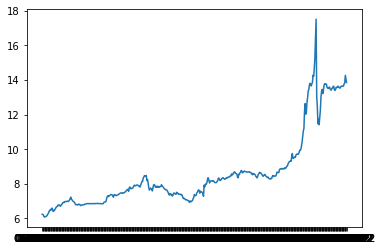

In [103]:
plt.plot(dolar['Dolar_Kuru'])

DataFrame oluşturabiliriz.

In [105]:
df = dolar['Dolar_Kuru']

In [106]:
print(df)

Tarih
02-03-2020     6.24
03-03-2020     6.23
04-03-2020     6.21
05-03-2020     6.10
06-03-2020     6.09
              ...  
23-02-2022    13.77
24-02-2022    13.81
25-02-2022    14.26
28-02-2022    14.06
01-03-2022    13.85
Name: Dolar_Kuru, Length: 501, dtype: float64


##### Veri seti önişlemesi

In [125]:
df = np.array(df).reshape(-1,1)

In [126]:
df

array([[1.31463628e-02],
       [1.22699387e-02],
       [1.05170903e-02],
       [8.76424189e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.62927257e-03],
       [3.50569676e-03],
       [6.13496933e-03],
       [1.31463628e-02],
       [1.66520596e-02],
       [2.45398773e-02],
       [3.24276950e-02],
       [3.24276950e-02],
       [3.85626643e-02],
       [3.59333918e-02],
       [4.46976337e-02],
       [3.68098160e-02],
       [2.80455741e-02],
       [3.33041192e-02],
       [3.15512708e-02],
       [3.85626643e-02],
       [4.29447853e-02],
       [4.90797546e-02],
       [5.17090272e-02],
       [5.34618755e-02],
       [5.95968449e-02],
       [5.78439965e-02],
       [6.04732691e-02],
       [5.78439965e-02],
       [5.34618755e-02],
       [5.95968449e-02],
       [6.13496933e-02],
       [6.74846626e-02],
       [7.27432077e-02],
       [7.36196319e-02],
       [7.27432077e-02],
       [7.71253287e-02],
       [7.80017528e-02],
       [7.71253287e-02],


Değerler yeniden ölçeklendirilebilir.

In [127]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [128]:
df = scaler.fit_transform(df)

In [129]:
df

array([[1.31463628e-02],
       [1.22699387e-02],
       [1.05170903e-02],
       [8.76424189e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.62927257e-03],
       [3.50569676e-03],
       [6.13496933e-03],
       [1.31463628e-02],
       [1.66520596e-02],
       [2.45398773e-02],
       [3.24276950e-02],
       [3.24276950e-02],
       [3.85626643e-02],
       [3.59333918e-02],
       [4.46976337e-02],
       [3.68098160e-02],
       [2.80455741e-02],
       [3.33041192e-02],
       [3.15512708e-02],
       [3.85626643e-02],
       [4.29447853e-02],
       [4.90797546e-02],
       [5.17090272e-02],
       [5.34618755e-02],
       [5.95968449e-02],
       [5.78439965e-02],
       [6.04732691e-02],
       [5.78439965e-02],
       [5.34618755e-02],
       [5.95968449e-02],
       [6.13496933e-02],
       [6.74846626e-02],
       [7.27432077e-02],
       [7.36196319e-02],
       [7.27432077e-02],
       [7.71253287e-02],
       [7.80017528e-02],
       [7.71253287e-02],


##### Training ve test setlerini ayırma

In [141]:
train = df[:350]
test = df[350:]

print(train.shape)
print(test.shape)

(350, 1)
(151, 1)


In [142]:
def get_data(data, look_back):
  datax, datay = [],[]
  for i in range(len(data)-look_back-1):
    datax.append(data[i:(i+look_back),0])
    datay.append(data[i+look_back,0])
  return np.array(datax) , np.array(datay)

In [143]:
look_back = 1

x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)

(348, 1)
(348,)


In [144]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(149, 1)
(149,)


##### LSTM modeli için training ve test setlerini işleme

In [145]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [146]:
print(x_train.shape)
print(x_test.shape)

(348, 1, 1)
(149, 1, 1)


##### LSTM modelini tanımlama

In [147]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [148]:
n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(1,1)))
model.add(Dense(n_features))

In [149]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


##### Derleme

In [150]:
model.compile(optimizer='adam', loss = 'mse')

##### Eğitim

In [151]:
model.fit(x_train,y_train, epochs = 5, batch_size=1)

Epoch 1/5
348/348 [==============================] - 2s 2ms/step - loss: 0.0037
Epoch 2/5
348/348 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 3/5
348/348 [==============================] - 1s 2ms/step - loss: 5.4412e-04
Epoch 4/5
348/348 [==============================] - 1s 2ms/step - loss: 1.0409e-04
Epoch 5/5
348/348 [==============================] - 1s 2ms/step - loss: 4.9022e-05


##### Eğitilmiş modeli kullanarak tahmin

In [152]:
scaler.scale_

array([1.])

In [153]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred[:10])

[[0.21342933]
 [0.20609477]
 [0.2033543 ]
 [0.19788983]
 [0.20609477]
 [0.2161898 ]
 [0.21987897]
 [0.22728652]
 [0.22543098]
 [0.22543098]]


##### Test verisini işleme

In [154]:
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
print(y_test[:10])

[[0.20508326]
 [0.20245399]
 [0.19719544]
 [0.20508326]
 [0.21472393]
 [0.21822962]
 [0.22524102]
 [0.22348817]
 [0.22348817]
 [0.21910605]]


##### Sonuçları görselleştirme

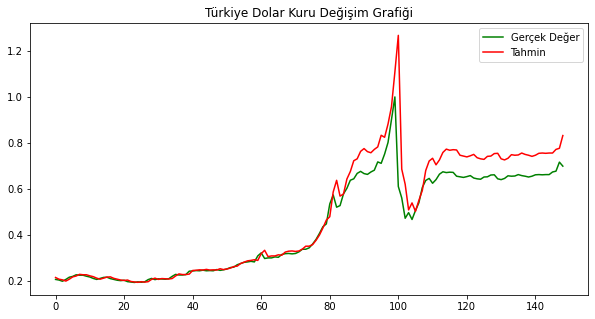

In [159]:
plt.figure(figsize=(10,5))
plt.title('Türkiye Dolar Kuru Değişim Grafiği')
plt.plot(y_test , label = 'Gerçek Değer', color = 'g')
plt.plot(y_pred , label = 'Tahmin', color = 'r')
plt.legend()

In [165]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.006311889766784423